In [2]:
%matplotlib widget

import tensorflow as tf
import os
import sys
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D
from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import RadiusNeighborsClassifier

In [3]:
DATASET_PATH = "/Users/jeremy/Google Drive/datasets/fashion-dataset/"
print(os.listdir(DATASET_PATH))

['embeddings.tsv', '.DS_Store', 'images.csv', 'images', 'styles', 'styles.csv', '.ipynb_checkpoints', 'embeddings.csv', 'resnet50-embeddings.pkl']


In [4]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [4]:
# Load ResNet-50 model pretrained on Imagenet without the classifying layers on top.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add Global Max Pooling layer on top
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [37]:
def get_img_path(img):
  return DATASET_PATH + "images/" + img

In [6]:
def extract_embeddings(img_name, model):
  input_shape = (224, 224, 3)
  img = image.load_img(get_img_path(img_name), target_size=(input_shape[0], input_shape[1]))
  img_array = image.img_to_array(img)
  expanded_img_array = np.expand_dims(img_array, axis=0)
  preprocessed_img = preprocess_input(expanded_img_array)
  embeddings = model.predict(preprocessed_img)
  return embeddings.reshape(-1)

In [7]:
emb = extract_embeddings(df.iloc[0].image, model)
emb.shape

(2048,)

(2400, 1800, 3)
[ 5.661311   2.366158   0.        ...  1.3138627  0.        10.820534 ]


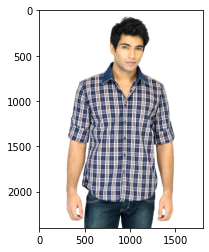

In [16]:
img_array = cv2.imread(get_img_path(df.iloc[0].image))
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [ ]:
# Create embeddings and store them into dataframe
df_sample      = df#.sample(10)
map_embeddings = df_sample['image'].apply(lambda img: extract_embeddings(img, model))
df_embs        = map_embeddings.apply(pd.Series)

In [ ]:
# Serialize dataframe to pickle file
df_embs.to_pickle(DATASET_PATH + "resnet50-embeddings.pkl")

In [5]:
df_embs = pickle.load(open(DATASET_PATH + "resnet50-embeddings.pkl", "rb"))

In [6]:
# Perform PCA over the embeddings to reduce dimensionality before applying t-sne
num_feature_dimensions = 100  # Set the number of embedding dimensions
pca = PCA(n_components = num_feature_dimensions)
pca.fit(df_embs)
embs_compressed = pca.transform(df_embs)
df_embs_compressed = pd.DataFrame(embs_compressed)

In [7]:
df_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,5.661316,2.366165,0.000000,3.255730,0.845208,2.673841,8.780870,6.280786,0.787188,1.587657,...,2.463610,0.000000,1.825994,20.485268,3.902863,0.000000,8.225969,1.313863,0.000000,10.820526
1,5.790417,9.593648,0.000000,9.431670,0.287235,0.259945,17.028748,3.037453,0.136341,0.000000,...,1.670570,0.013891,10.338681,4.784722,0.189140,0.000000,7.739144,0.372693,0.000000,8.903802
2,0.000000,3.162254,0.484691,0.172299,2.609548,3.840852,3.426139,0.253253,1.098907,1.418282,...,0.434926,14.092834,3.018744,2.134506,2.549062,0.377385,6.180348,0.636620,14.018165,11.415048
3,5.882203,1.958606,0.000000,12.519882,0.000000,0.000000,9.383594,3.781614,0.000000,1.490617,...,17.825478,0.000000,3.592507,2.042305,0.000000,0.000000,6.656779,1.457314,1.694204,1.403327
4,0.245968,17.383430,0.493824,3.374468,2.567368,0.000000,6.482537,5.862639,0.000000,3.164866,...,4.464024,0.447075,1.448143,12.884138,0.000000,0.397501,5.028075,1.939697,0.000000,11.485400


In [8]:
df_embs_compressed.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-106.875038,-38.914085,0.338673,19.187391,14.934881,-24.084839,-7.463208,3.361347,21.677277,-9.196446,...,-3.935245,-5.137181,-0.489051,5.229190,7.058326,2.754213,-3.108736,5.220242,1.828035,-5.977281
1,-97.877396,-42.474079,-8.299008,-21.014059,30.330563,-65.437302,18.467808,12.433029,29.025610,13.180144,...,1.005705,-4.873087,-2.039888,-2.373681,-1.869032,0.269871,0.854167,8.639016,-7.476703,4.456782
2,24.955391,105.210327,-22.968163,69.645859,26.989819,-7.557511,29.481039,-29.776167,9.603579,-11.336097,...,2.889512,-20.296875,0.207704,4.447514,-4.918386,-2.134432,-4.927571,0.756916,-0.051984,6.961241
3,-83.753212,-23.995644,-13.961485,-31.153416,28.798855,-46.637833,9.314631,17.459827,31.331917,24.376511,...,-10.118686,-1.989460,-5.923496,-6.314288,3.715336,0.946690,-1.633909,12.759863,-15.257922,4.650401
4,-106.195831,-32.474937,-13.414430,-0.511964,15.810200,-40.974754,8.317142,5.499653,-25.244215,-11.114786,...,-4.131853,-1.946706,7.780653,12.366483,0.664422,3.651281,8.536223,-3.612312,-2.417322,-0.464770


In [9]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs_compressed)

In [10]:
df['x'] = tsne_results[:,0]
df['y'] = tsne_results[:,1]

In [11]:
def create_axis():
    axis_color = 'k'
    x = np.linspace(-15, 15)
    y = np.linspace(0, 0)
    lines = plt.plot(x, y, axis_color, linewidth=2)

In [12]:
def create_user_marker(x=0):
    user_marker = plt.plot(x, 0, 'yo', markersize=10)
    user_position = np.array([x, 0])
    return user_marker, user_position

In [13]:
def get_nearest_neighbour(user_position, df):
   nearest_neighbour = None
   nearest_neighbour_pos = None
   smallest_dist = sys.maxsize
   for row in df.itertuples():
      embedding_position = np.array([row.x, row.y])
      dist = norm(user_position - embedding_position)
      if dist < smallest_dist:
         smallest_dist = dist
         nearest_neighbour = row.id
         nearest_neighbour_pos = embedding_position
   return nearest_neighbour, nearest_neighbour_pos

In [14]:
def highlight_nearest_neighbour(id, df):
    x_nn = df.loc[df['id'] == id].x.values[0]
    y_nn = df.loc[df['id'] == id].y.values[0]
    plt.scatter(x=x_nn, y=y_nn, color='r')

In [15]:
def update_user_position(change):
    user_marker[0].set_data(change.new, 0)
    new_user_pos = np.array([change.new, 0])
    nearest_neighbour, nearest_neighbour_pos = get_nearest_neighbour(new_user_pos, df)
    plt.title('Nearest Embedding: {}'.format(nearest_neighbour))
    fig.canvas.draw()
    fig.canvas.flush_events()

In [51]:
def annotate_nearest_neighbour(nearest_neighbour, nearest_neighbour_pos, ax, df):
    if ax.artists != []:
        ax.artists[0].remove()
    arr_img = plt.imread(get_img_path(df.loc[df['id'] == nearest_neighbour].image.values[0]))
    imagebox = OffsetImage(arr_img, zoom=0.02)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, nearest_neighbour_pos, xybox=(-20, 40), xycoords='data', boxcoords="offset points", arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)

In [23]:
print(df.loc[df['id'] == 25111].image.values[0])

25111.jpg


In [18]:
df.loc[df['id'] == 48114]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,x,y
2892,48114,Women,Accessories,Belts,Belts,Multi,Summer,2012,Casual,Fossil Women Multi Coloured Quilted Squares Belt,48114.jpg,-1.497729,-0.554641


In [52]:
from ipywidgets import AppLayout, FloatSlider
from matplotlib.offsetbox import (AnnotationBbox, OffsetImage, TextArea)

plt.ioff()

slider = FloatSlider(
    orientation="horizontal",
    description="Position:",
    value=0.0,
    min=-15.0,
    max=15.0
)

slider.layout.margin = '0px 30% 0px 30%'
slider.layout.width = '40%'

fig, ax = plt.subplots(figsize=(12,7))
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'
sns.scatterplot(x="x", y="y",
                  hue="masterCategory", # can be replaced with `subCategory` to see more details
                  data=df,
                  legend="full",
                  alpha=0.8)

create_axis()
user_marker, user_positon = create_user_marker()
nearest_neighbour, nearest_neighbour_pos = get_nearest_neighbour(user_positon, df)
annotate_nearest_neighbour(nearest_neighbour, nearest_neighbour_pos, ax, df)

plt.title('Nearest Embedding: {}'.format(nearest_neighbour))

def update_user_position(change):
    user_marker[0].set_data(change.new, 0)
    new_user_pos = np.array([change.new, 0])
    nearest_neighbour, nearest_neighbour_pos = get_nearest_neighbour(new_user_pos, df)
    annotate_nearest_neighbour(nearest_neighbour, nearest_neighbour_pos, ax, df)
    plt.title('Nearest Embedding: {}'.format(nearest_neighbour))
    fig.canvas.draw()
    fig.canvas.flush_events()

slider.observe(update_user_position, names='value')

AppLayout(
    center=fig.canvas,
    footer=slider,
    pane_heights=[0, 6, 1]
)

AppLayout(children=(FloatSlider(value=0.0, description='Position:', layout=Layout(grid_area='footer', margin='…